# Identified glycopeptides compared across and within samples

The following notebook contains the code used to extract, transform, and represent the data viewed in the associated manuscript. If at any point you would like to use this code or consult over its various components, please reach out to me via my github contact information.

In [3]:
import sys 
sys.path.append(r'../.')
from commons.data_processing import *
from commons.byonic import *
from modlamp.descriptors import PeptideDescriptor
from altair.expr import datum
from venn import venn
import re
import os
import ntpath
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

First we will define functions used throughout the notebook

In [4]:
# define functions reused throughout the notebook

def create_ident(dataframe, columns):
    '''
    This function creates a unique string that combines
    each characteristic provided in columns.
    
    :param(dataframe): (pd.DataFrame) dataframe containing Byonic output
    :param(columns): (list) columns to be combined

    Ex: 
        df = peptide seq  |  glycan  |  charge
             ---------------------------------
              PEPTIDER   HexNax(2)Hex(5)  2
        
    >>> create_ident(['peptide seq', 'glycan', 'charge'])
    >>> 'PEPTIDER_HexNax(2)Hex(5)_2'
    '''
    err_str =  'Only list-like items accepted in func create_ident()'
    assert isinstance(columns, list), err_str

    sub = dataframe[columns]
    for col in sub:
        sub.loc[:, col] = sub[col].astype(str)
    sub['res'] = sub[columns].apply(list, axis=1)
    return ['_'.join(item) for item in sub.res]

def num_sacch(s):
    '''
    This function counts the number of listed glucose
    units according to a byonic output:
    
    :param(s): (str) string of glycan
    
    Ex: s = 'HexNAc(2)Hex(5)'
        >>> num_sacch(s)
        >>> 7 
    '''
    pattern = re.compile(r'[0-9]+')
    match = re.findall(pattern, s)
    match = [int(i) for i in match]
    return sum(match)

def combine_dfs(d1, d2):
    '''Functions used to combine two pandas dataframes.'''
    if d1.empty:
        return d2
    else:
        return pd.concat([d1, d2], axis=0)

def categorize_glycan(s):
    '''
    Function used to categorize glycans as either Sialylated,
    Fucosylated, High Mannose, Complex, or Paucimannose.
    '''
    s = s.replace(')', ',')
    s = s.replace('(', ' ')
    s = s.split(',')[:-1]
    d = {k:int(v) for [k, v] in [i.split(' ') for i in s]}

    if 'NeuAc' in d or 'NeuGc' in d:
        return 'Sialylated'
    elif 'Fuc' in d:
        if d['HexNAc'] > 2:
            return 'Fucosylated'
        elif d['HexNAc'] == 2:
            if 'Hex' in d:
                if d['Hex'] > 4:
                    return 'Complex'
                else:
                    return 'Paucimannose' 
    # elif 'Fuc' in d and d['HexNAc'] > 2:
    #     return 'Fucosylated'
    elif d['HexNAc'] > 2:
        return 'Complex'
    if d['HexNAc'] <= 2:
        if 'Hex' in d:
            if d['Hex'] <= 9 and d['Hex'] > 4:
                return 'High Mannose'
        return 'Paucimannose'

def pour(s):
    '''
    Function that calculates overall GRAVY score for a given peptide.
    '''
    err_doc = f'Not all data entered as string: error in {s} type is {type(s)}'
    assert isinstance(s, str), err_doc
    desc = PeptideDescriptor(s, 'gravy')
    desc.calculate_global()
    return desc.descriptor[0][0]

Here we located the byonic output .xlsx files to read their contents

In [5]:
# the get files function can be located in 'commons/data_processing'
files = get_files(exts=['.xlsx'])

Next we will use custom class methods to parse byonic files, extract valid glycopeptides and store them in a useable dataframe. We will also plot total and unique species.

In [6]:
# what is count of unique and total glycopeptides in each experiment

title, kind, val, experiment = [], [], [], []
for file in files:
    exp = file.split('\\')[1]
    base = ntpath.basename(file)
    base, _ = ntpath.splitext(base)
    title.extend([base]*2)
    kind.extend(['total', 'unique'])
    print(f'In file {file}:')
    bf = ByFile(file)
    bf.fill_no_glycans()
    bf.remove_reverse(modify=True)
    bf.determine_glycosites()
    bf.filter_hits(modify=True, score=200)
    bf.frame = bf.reduce_frame(gp_only=True)
    total = bf.total_gp()
    val.append(len(total))
    print('\t\t', f'found {len(total)} glycopeptides in total')
    unique = bf.unique_gp()
    experiment.extend([exp]*2)
    
    val.append(len(unique))
    print('\t\t', f'found {len(unique)} unique glycopeptides')
    print('\n')

print(len(val), len(title), len(kind), len(experiment))

df = pd.DataFrame({
    'experiment':experiment,
    'condition':title,
    'kind':kind,
    'value':val
})

df.loc[:, "column"] = df.condition.str.split('_', expand=True).iloc[:, 0]
domain = df.column.unique().tolist()
dom = {
    [d for d in domain if re.search('PGC', d)][0]: '#cc7833',
    [d for d in domain if re.search('BP', d)][0]: '#86858f',
    [d for d in domain if re.search('C18', d)][0]: '#43648c'
}

bars = alt.Chart(df).mark_bar().encode(
    x=alt.X('kind:O', title=''),
    y=alt.Y('sum(value):Q', title='Peptide Count'),
    color=alt.Color('column:N', scale=alt.Scale(
            domain=list(dom.keys()), range=list(dom.values())
    )),
    column='condition:O'
)

bars.properties(
    title='Glycopeptides across all samples'
)

bars.save('Cross_Sample_Comparisons/Glycopeptide_BarPlot_AllSamples.svg')
bars

In file .\NT1\BP_30C\BP_30C.xlsx:
		 found 8 glycopeptides in total
		 found 8 unique glycopeptides


In file .\NT1\BP_45C\BP_45C.xlsx:
		 found 17 glycopeptides in total
		 found 16 unique glycopeptides


In file .\NT1\BP_60C\BP_60C.xlsx:
		 found 7 glycopeptides in total
		 found 7 unique glycopeptides


In file .\NT1\C18_30C\C18_30C.xlsx:
		 found 119 glycopeptides in total
		 found 105 unique glycopeptides


In file .\NT1\C18_45C\C18_45C.xlsx:
		 found 241 glycopeptides in total
		 found 212 unique glycopeptides


In file .\NT1\C18_60C\C18_60C.xlsx:
		 found 184 glycopeptides in total
		 found 165 unique glycopeptides


In file .\NT1\PGC_30C\PGC_30C.xlsx:
		 found 170 glycopeptides in total
		 found 143 unique glycopeptides


In file .\NT1\PGC_45C\PGC_45C.xlsx:
		 found 199 glycopeptides in total
		 found 166 unique glycopeptides


In file .\NT1\PGC_60C\PGC_60C.xlsx:
		 found 156 glycopeptides in total
		 found 137 unique glycopeptides


In file .\StdEnr\BP_30C\BP_30C.xlsx:
		 foun

alt.Chart(...)

We can also devide these up by experiment/sample

In [7]:
# break up bar charts by experiment 
chart = alt.vconcat()
for exp in df.experiment.unique():
    chart &= bars.transform_filter(datum.experiment==exp).properties(title=f'Glycopeptides in {exp}'
    )
chart.save('Cross_Sample_Comparisons/Glycopeptides_BarPlot_SingleSample.svg')
chart

alt.VConcatChart(...)

Here we create a pyramid plot to show total and unique glycopeptides

In [11]:
df.loc[:, "column"] = df.condition.str.split('_', expand=True).iloc[:, 0]
domain = df.column.unique().tolist()
dom = {
    [d for d in domain if re.search('PGC', d)][0]: '#cc7833',
    [d for d in domain if re.search('BP', d)][0]: '#86858f',
    [d for d in domain if re.search('C18', d)][0]: '#43648c'
}

base = alt.Chart(df).properties(
    width=250,
    height=225
)


left = base.transform_filter(
    alt.datum.kind == 'total'
).encode(
    y=alt.Y('condition:O', axis=None),
    x=alt.X('sum(value):Q', title='Total',
            sort=alt.SortOrder('descending'),
            scale=alt.Scale(domain=(0, 800)),
            axis=alt.Axis(tickCount=4)),
    color=alt.Color('column:O', scale=alt.Scale(
            domain=list(dom.keys()), range=list(dom.values())
    ))
).mark_bar().properties(title='Total')


middle = base.encode(
    y=alt.Y('condition:O', axis=None),
    text=alt.Text('condition:O'),
).mark_text().properties(width=60)

right = base.transform_filter(
    alt.datum.kind == 'unique'
).encode(
    y=alt.Y('condition:O', axis=None),
    x=alt.X('sum(value):Q', title='Unique',
            scale=alt.Scale(domain=(0, 800)),
            axis=alt.Axis(tickCount=4)),
    color=alt.Color('column:O', scale=alt.Scale(
            domain=list(dom.keys()), range=list(dom.values())
    ))
).mark_bar().properties(title='Unique')

alt.concat(left, middle, right, spacing=5).save('Cross_Sample_Comparisons/TotalGlcyopeptides_Pyramid.svg')
alt.concat(left, middle, right, spacing=5)

alt.ConcatChart(...)

## Creating aggregate dataframe

The following cell combines all byonic output in a dataframe nammed 'agg' (aggregate), which is used throughout

In [12]:
all_gpeps = {}
agg = pd.DataFrame()
for file in files:
    exp = file.split('\\')[1]
    base = ntpath.basename(file)
    base, _ = ntpath.splitext(base)
    spl = base.split('_')
    base, temp = spl[0], spl[1]
    print(f'Parsing file {file}')
    bf = ByFile(file)
    bf.fill_no_glycans()
    bf.remove_reverse(modify=True)
    bf.determine_glycosites()
    bf.filter_hits(modify=True, score=200)
    bf.frame = bf.reduce_frame(gp_only=True)
    total = bf.total_gp()
    total.loc[:, 'experiment'] = [exp]*len(total)
    total.loc[:, 'column'] = [base]*len(total)
    total.loc[:, 'temperature'] = [temp]*len(total)
    total.loc[:, 'condition'] = ['_'.join([base, temp])]*len(total)
    all_gpeps[exp+'.'+base] = set(create_ident(total, ['clean_peptide', 'glycan', 'z']))
    if agg.empty:
        agg = total
        continue
    agg = pd.concat([agg, total], axis=0)
agg.loc[:, 'glycan_type'] = agg.glycan.map(categorize_glycan)

Parsing file .\NT1\BP_30C\BP_30C.xlsx
Parsing file .\NT1\BP_45C\BP_45C.xlsx
Parsing file .\NT1\BP_60C\BP_60C.xlsx
Parsing file .\NT1\C18_30C\C18_30C.xlsx
Parsing file .\NT1\C18_45C\C18_45C.xlsx
Parsing file .\NT1\C18_60C\C18_60C.xlsx
Parsing file .\NT1\PGC_30C\PGC_30C.xlsx
Parsing file .\NT1\PGC_45C\PGC_45C.xlsx
Parsing file .\NT1\PGC_60C\PGC_60C.xlsx
Parsing file .\StdEnr\BP_30C\BP_30C.xlsx
Parsing file .\StdEnr\BP_45C\BP_45C.xlsx
Parsing file .\StdEnr\BP_60C\BP_60C.xlsx
Parsing file .\StdEnr\C18_30C\C18_30C.xlsx
Parsing file .\StdEnr\C18_45C\C18_45C.xlsx
Parsing file .\StdEnr\C18_60C\C18_60C.xlsx
Parsing file .\StdEnr\PGC_30C\PGC_30C.xlsx
Parsing file .\StdEnr\PGC_45C\PGC_45C.xlsx
Parsing file .\StdEnr\PGC_60C\PGC_60C.xlsx
Parsing file .\T10\BP_30C\BP_30C.xlsx
Parsing file .\T10\BP_45C\BP_45C.xlsx
Parsing file .\T10\BP_60C\BP_60C.xlsx
Parsing file .\T10\C18_30C\C18_30C.xlsx
Parsing file .\T10\C18_45C\C18_45C.xlsx
Parsing file .\T10\C18_60C\C18_60C.xlsx
Parsing file .\T10\PGC_30C\PGC_

In [13]:
# we can pull out a single protein as an example
agg[agg.protein_name.str.contains('P35613')].head()

clean_peptide           glycan  z  observed_mz  calc._mass_mh  \
3664  ILLTCSLNDSATEVTGHR  HexNAc(2)Hex(6)  3    1122.4982      3365.4670   
4948  ILLTCSLNDSATEVTGHR  HexNAc(2)Hex(6)  3    1122.5017      3365.4670   
3693  ILLTCSLNDSATEVTGHR  HexNAc(2)Hex(6)  3    1122.5025      3365.4670   
2862  ILLTCSLNDSATEVTGHR  HexNAc(2)Hex(6)  3    1122.5008      3365.4670   
2867           ALMNGSESR  HexNAc(2)Hex(6)  2    1171.9725      2342.9273   

      glycosite   score  delta_mod  log_prob  \
3664        161  209.72     131.50      7.57   
4948        161  236.83     153.53      7.46   
3693        161  253.96     167.21      8.72   
2862        161  291.48     132.90      4.87   
2867        269  244.73      25.51      3.16   

                                         peptide  \
3664  K.ILLTC[+57.021]SLN[+1378.476]DSATEVTGHR.W   
4948  K.ILLTC[+57.021]SLN[+1378.476]DSATEVTGHR.W   
3693  K.ILLTC[+57.021]SLN[+1378.476]DSATEVTGHR.W   
2862  K.ILLTC[+57.021]SLN[+1378.476]DSATEVTGHR.W   
2867                    K.ALMN[+1378.476]GSESR.F   

                                           protein_name  scan_time experiment  \
3664  >sp|P35613|BASI_HUMAN Basigin OS=Homo sapiens ...    39.1108        NT1   
4948  >sp|P35613|BASI_HUMAN Basigin OS=Homo sapiens ...    35.5039        NT1   
3693  >sp|P35613|BASI_HUMAN Basigin OS=Homo sapiens ...    35.6828        NT1   
2862  >sp|P35613|BASI_HUMAN Basigin OS=Homo sapiens ...    55.6420        NT1   
2867  >sp|P35613|BASI_HUMAN Basigin OS=Homo sapiens ...    38.6428        NT1   

     column temperature condition   glycan_type  
3664    C18         30C   C18_30C  High Mannose  
4948    C18         45C   C18_45C  High Mannose  
3693    C18         60C   C18_60C  High Mannose  
2862    PGC         30C   PGC_30C  High Mannose  
2867    PGC         30C   PGC_30C  High Mannose

Let's plot the unique glycopeptide identifications by experiment to make sure we get the same result as before

In [14]:
reduced = agg.drop_duplicates()

domain = reduced.column.unique().tolist()
dom = {
    [d for d in domain if re.search('PGC', d)][0]: '#cc7833',
    [d for d in domain if re.search('BP', d)][0]: '#86858f',
    [d for d in domain if re.search('C18', d)][0]: '#43648c'
}

bars = alt.Chart(reduced).mark_bar().encode(
    x=alt.X('condition:O', title=''),
    y=alt.Y('count(peptide):O', title=''),
    column='experiment:O',
    color=alt.Color('column:O', scale=alt.Scale(domain=list(dom.keys()), range=list(dom.values())))
).properties(
    width=250
)
bars

alt.Chart(...)

## Venn 

We can plot the overlap of glycopeptides by creating a set of peptides from each column and using the 'venn' package

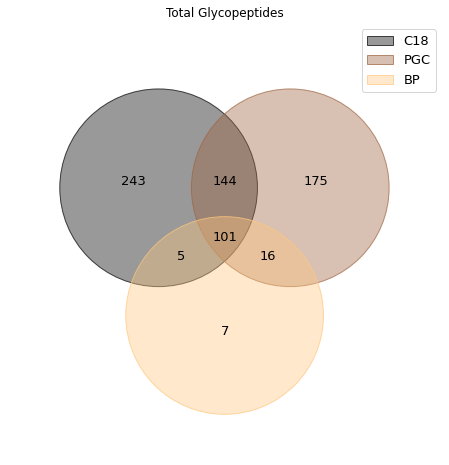

In [18]:
# what is overlap of glycopeptides across all experiments

pgc = set(agg[agg.column=='PGC'].peptide.tolist()) # remove duplicates
c18 = set(agg[agg.column=='C18'].peptide.tolist()) # remove duplicates
bp = set(agg[agg.column=='BP'].peptide.tolist()) # remove duplicates

t = dict(zip(
    ['C18', 'PGC', 'BP'],
    [c18, pgc, bp]
))
venn(t, cmap='copper')
plt.title('Total Glycopeptides')
plt.savefig('Cross_Sample_Comparisons/TotalGlycopeptides_Venn_ByColumn.svg')

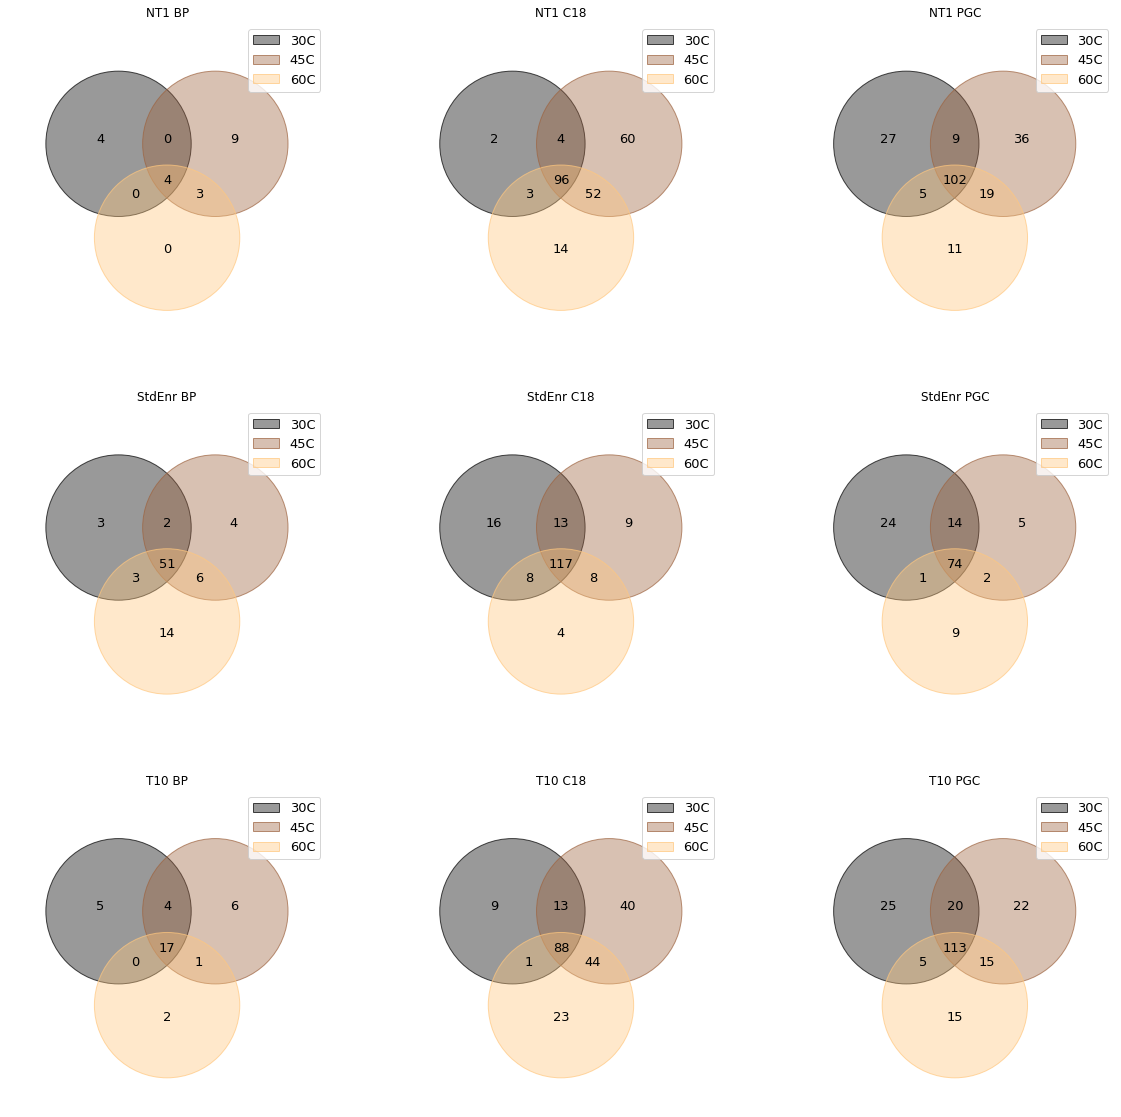

In [19]:
# glycopeptides when column type is same

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
e = []
exps = agg.experiment.unique().tolist()
cols = agg.column.unique().tolist()


for i, row in enumerate(axs):
    exp = exps[i]

    for j, ax in enumerate(row):
        col = cols[j]
        body = agg[(agg.experiment==exp) & (agg.column==col)]
        l = {}
        for temp in body.temperature.unique():
            l[temp] = set(body[body.temperature==temp]['peptide'])
        venn(l, ax=ax, cmap='copper')
        ax.set_title(exp + ' ' + col)

plt.savefig('Cross_Sample_Comparisons/Glycopeptides_Venn_BySample+Column.svg')

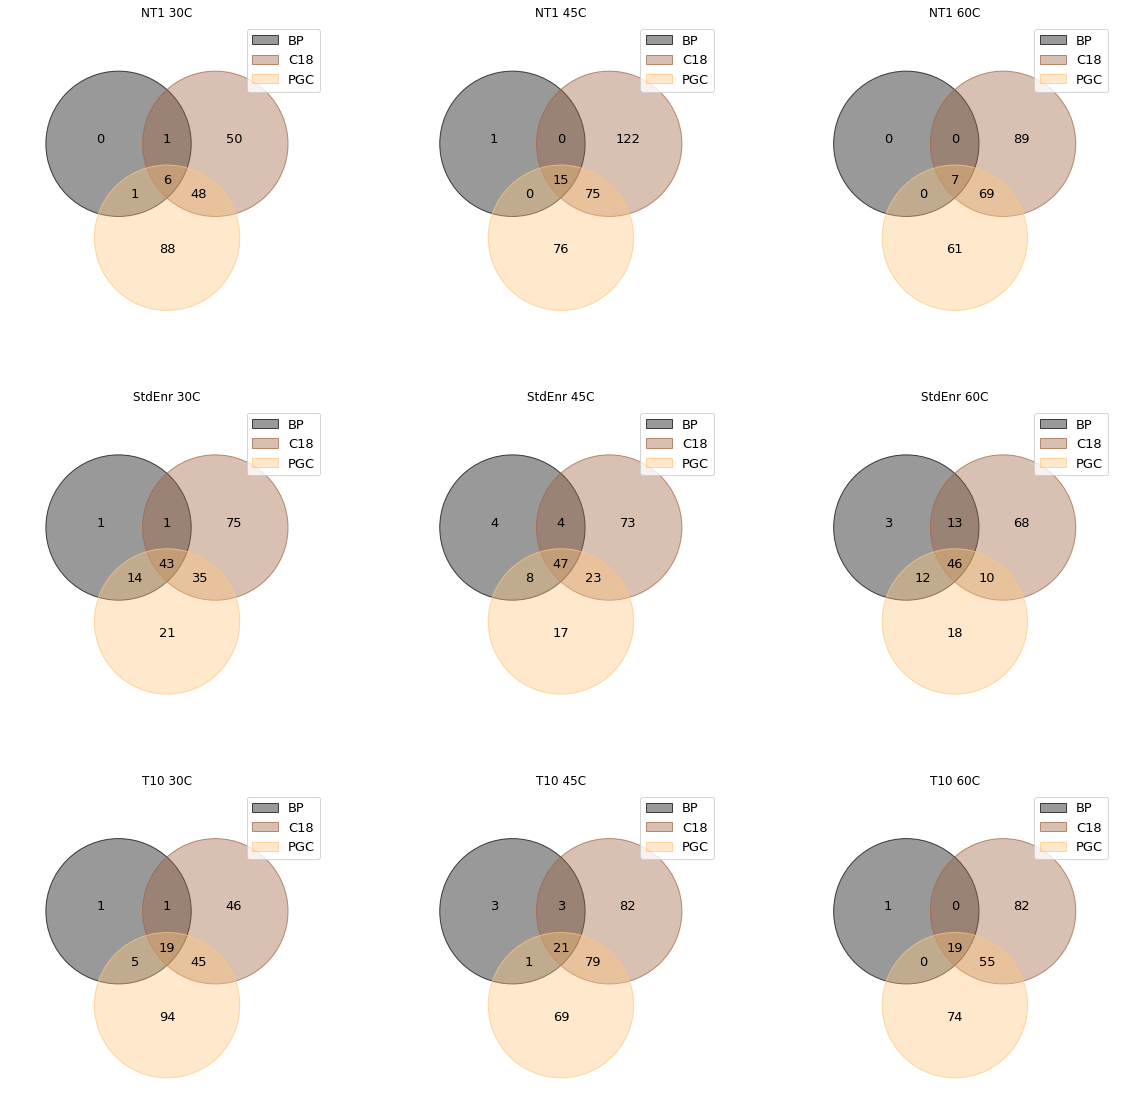

In [20]:
# glycopeptides when temp is same

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
e = []
exps = agg.experiment.unique().tolist()
temps = agg.temperature.unique().tolist()


for i, row in enumerate(axs):
    exp = exps[i]
    for j, ax in enumerate(row):
        temp = temps[j]
        body = agg[(agg.experiment==exp) & (agg.temperature==temp)]
        l = {}
        for col in body.column.unique():
            l[col] = set(body[body.column==col]['peptide'])
        venn(l, ax=ax, cmap='copper')
        ax.set_title(exp + ' ' + temp)
plt.savefig('Cross_Sample_Comparisons/Glycopeptides_Venn_BySample+Temperature.svg')

## Peptide Character

In order to establish the underlying trends in identified species, we can iterate through the dataframe and compile all identified glycopeptides and then sort them into unique groups 

In [21]:
# first we will go through each experiment and find all glycopeptides
res = {}
for experiment in agg.experiment.unique():
    body = agg[agg.experiment==experiment]
    b = {}
    for column in body.column.unique():
        tail = body[body.column==column]
        # here we will create a unique string for glycopeptides, which is used later
        b[column] = set(create_ident(tail, ['clean_peptide', 'glycan', 'z']))
    res[experiment] = b


# now we will go through the dictionary and sort glycopeptides according to 
# 'RPLC', 'PGC', or 'BP'
# The output will contain only those species found to be unique
master = {}
for exp in res:
    head = res[exp]
    bp = head['BP']
    pgc = head['PGC']
    c18 = head['C18']
    b, p, c, = [], [], []
    for item in bp:
        if item not in pgc and item not in c18:
            b.append(item)
    for item in c18:
        if item not in pgc and item not in bp:
            c.append(item)
    for item in pgc:
        if item not in bp and item not in c18:
            p.append(item)
    sub = {'PGC':p, 'C18':c, 'BP':b}
    master[exp] = sub

In [22]:
# here we will parse through the unique glycopeptides to learn more about them 

experiment = []
columns = []
char = []
values = []

for exp in master:
    body = master[exp]
    for column in body:
        v = []
        peptides = body[column]
        tot = len(peptides)
        d = {}
        g = {}
        for p in peptides:
            back, glyc, z = p.split('_')
            d[back] = None
            g[glyc] = None

            # add in peptide length
            v.append(len(back))
            char.append('Average Length')
            
            # add in peptide charge
            v.append(int(z))
            char.append('Average Charge')
            
            # add in normalized charge
            v.append(int(z) / len(back))
            char.append('Norm Charge')
            
            # add in number of glucose units
            v.append(_x:=num_sacch(glyc))
            char.append('Num G.U')
            
            # add in normalized glucose units
            v.append(num_sacch(glyc) / len(back))
            char.append('G:P Ratio')
        
        v.append(len(d)) # num unique backbones
        v.append(len(g)) # num unique glycans

        char.extend(['Unique Backbones', 'Unique Glycans'])
        experiment.extend([exp]*len(v))
        columns.extend([column]*len(v))
        values.extend(v)
    print(len(experiment), len(columns), len(char), len(values))

unique_gp = pd.DataFrame({'experiment':experiment, 'column':columns, 'type':char, 'value':values})
unique_gp.head()

1356 1356 1356 1356
2222 2222 2222 2222
3378 3378 3378 3378


experiment column            type   value
0        NT1    PGC  Average Length   8.000
1        NT1    PGC  Average Charge   3.000
2        NT1    PGC     Norm Charge   0.375
3        NT1    PGC         Num G.U  10.000
4        NT1    PGC       G:P Ratio   1.250

In [23]:
# Now we will plot the data across all experiments

domain = unique_gp.column.unique().tolist()
dom = {
    [d for d in domain if re.search('PGC', d)][0]: '#cc7833',
    [d for d in domain if re.search('BP', d)][0]: '#86858f',
    [d for d in domain if re.search('C18', d)][0]: '#43648c'
}

error_bars = alt.Chart(unique_gp).mark_errorbar(extent='ci').encode(
    x=alt.X('column:O'),
    y=alt.Y('mean(value):Q', scale=alt.Scale(zero=True)),
)

bars = alt.Chart(unique_gp).mark_bar().encode(
    x=alt.X('column:O', title=''),
    y=alt.Y('mean(value):Q', title=''),
    color=alt.Color('column:O', scale=alt.Scale(domain=list(dom.keys()), range=list(dom.values()))),
)

base = alt.layer(bars, error_bars).facet(
    column='type:O'
    ).resolve_scale(y='independent')
base.save('Cross_Sample_Comparisons/GPeptide_Character_All.svg')
base

alt.FacetChart(...)

In [24]:
# Here we plot the same data but break it up by experiment/sample
chart = alt.vconcat()
for exp in unique_gp.experiment.unique():
    chart &= base.transform_filter(datum.experiment==exp).resolve_scale(y='independent').properties(title=f'{exp}')
chart.save('Cross_Sample_Comparisons/GPeptide_Character_ByExp.svg')
chart

alt.VConcatChart(...)

## GPSMs

Here we go through the aggregate database and find all GPSMs

In [25]:
domain = agg.column.unique().tolist()
dom = {
    [d for d in domain if re.search('PGC', d)][0]: '#cc7833',
    [d for d in domain if re.search('BP', d)][0]: '#86858f',
    [d for d in domain if re.search('C18', d)][0]: '#43648c'
}

# count gpsms
bars = alt.Chart(agg).mark_bar().encode(
    x=alt.X('column:O', title=''),
    y=alt.Y('count(Peptide):Q', title='GPSMs'),
    color=alt.Color('column:O', scale=alt.Scale(domain=list(dom.keys()), range=list(dom.values())))
)

chart = alt.hconcat()
for exp in agg.experiment.unique():
    chart |= bars.transform_filter(datum.experiment==exp).properties(title=exp)
chart.resolve_scale(y='independent').properties(title='Glycopeptide Spectral Matches').save('Cross_Sample_Comparisons/GPSM_Bar_ByExperiment.svg')
chart.resolve_scale(y='independent')

alt.HConcatChart(...)

## Microheterogeneity differences

Here we will examine the number of glycans found for each unique backbone 

In [26]:
peptide, glycs, experiment, column, = [], [], [], []

# sort by sample
for exp in agg.experiment.unique():
    body = agg[agg.experiment==exp]

    # sort by column
    for col in body.column.unique():
        tail = body[body.column==col]
        counts = tail.peptide.value_counts()

        # determine # glycans per unique backbone
        for pep in tail.clean_peptide.unique():
            peptide.append(pep)
            glycs.append(len(tail[tail.clean_peptide==pep].glycan.unique()))
            experiment.append(exp)
            column.append(col)

data = pd.DataFrame({'experiment':experiment, 'column':column,
              'peptide':peptide, 'glycans':glycs})

dom = {
    [d for d in domain if re.search('PGC', d)][0]: '#cc7833',
    [d for d in domain if re.search('BP', d)][0]: '#86858f',
    [d for d in domain if re.search('C18', d)][0]: '#43648c'
}

box = alt.Chart(data).mark_boxplot().encode(
    x=alt.X('column:O', title=''),
    y=alt.Y('mean(glycans):Q', title='glycan count'),
    column='experiment:O',
    color=alt.Color('column:O', scale=alt.Scale(domain=list(dom.keys()), range=list(dom.values()))),
)

from altair.expr import datum

chart = alt.hconcat()
for t in data.experiment.unique():
    print(t)
    chart |= box.transform_filter(datum.experiment == t)

chart.resolve_scale(y='independent').save('Cross_Sample_Comparisons/Glycans_per_backbone.svg')
chart


NT1
StdEnr
T10


alt.HConcatChart(...)

## Charge state differences

Here we can examine the differences in charge state across all experiments

In [27]:
# plot distribution of charge states across all experiments
charges = agg[['z', 'experiment', 'column', 'temperature']]
charges.loc[:, 'identifier'] = ["_".join(z) for z in zip(charges.column, charges.temperature)]

domain = data.column.unique().tolist()
dom = {
    [d for d in domain if re.search('PGC', d)][0]: '#cc7833',
    [d for d in domain if re.search('BP', d)][0]: '#86858f',
    [d for d in domain if re.search('C18', d)][0]: '#43648c'
}

dots = alt.Chart(charges).mark_circle().encode(
    x=alt.X('z:Q', title='Charge state', axis=alt.Axis(format='+'+'.0f', tickMinStep=1)),
    y=alt.Y('identifier:O', title='Experiment'),
    color=alt.Color('column:O', scale=alt.Scale(domain=list(dom.keys()), range=list(dom.values()))),
    size='count()'
).properties(
    title='Charge States (All experiments)'
)
dots.save('Cross_Sample_Comparisons/ChargeState_Dotplot_AllExperiments.svg')
dots

alt.Chart(...)

In [28]:
# break down charge states by experiment/sample
domain = data.column.unique().tolist()
dom = {
    [d for d in domain if re.search('PGC', d)][0]: '#cc7833',
    [d for d in domain if re.search('BP', d)][0]: '#86858f',
    [d for d in domain if re.search('C18', d)][0]: '#43648c'
}

dots = alt.Chart(charges).mark_circle().encode(
    x=alt.X('z:Q', title='Charge state', axis=alt.Axis(format='+'+'.0f', tickMinStep=1)),
    y=alt.Y('identifier:O', title='Experiment'),
    color=alt.Color('column:O', scale=alt.Scale(domain=list(dom.keys()), range=list(dom.values()))),
    size='count()'
)

chart = alt.vconcat()
for e in charges.experiment.unique():
    chart &= dots.transform_filter(datum.experiment==e).properties(
        title=f'{e}'
    )

chart.resolve_scale(x='shared').save('Cross_Sample_Comparisons/ChargeState_Dotplot_BySample.svg')
chart.resolve_scale(x='shared')

alt.VConcatChart(...)

## Glycoproteome profiling

Here we will plot the distribution of glycan combisitions in all experiments

In [31]:
# plot distribution of glycan types
types = agg[['clean_peptide', 'z', 'peptide', 'glycan', 'experiment', 'column',
             'temperature', 'glycan_type']]
types.loc[:, 'identifier'] = ["_".join(z) for z in zip(types.column, types.temperature)]

pgc = set(types[types.column=='PGC'].peptide.unique())
c18 = set(types[types.column=='C18'].peptide.unique())
bp = set(types[types.column=='BP'].peptide.unique())
print(len(pgc), len(c18), len(bp))

p_unique = pgc - c18 - bp 
c_unique = c18 - bp - pgc 
b_unique = bp - pgc - c18
print(len(p_unique), len(c_unique), len(b_unique))

union = list(p_unique | c_unique | b_unique)

types_test = types[types.peptide.isin(union)].drop_duplicates()

glycan_color_scale = alt.Scale(
    domain=[
        'Sialylated',
        'Fucosylated',
        'Complex',
        'Paucimannose',
        'High Mannose',
    ],
    range=[
        '#6E6581',
        '#AF3A53',
        '#6B8A97',
        '#B0B2BB',
        '#658A64',
    ]
)

bars = alt.Chart(types_test).mark_bar().encode(
    x=alt.X('count(glycan_type):O', title=''),
    y=alt.Y('identifier:O', title=''),
    color=alt.Color('glycan_type:O', scale=glycan_color_scale)
)
bars.save('Cross_Sample_Comparisons/GlycanType_StackedBar_AllSamples.svg')
bars

436 493 129
175 243 7


alt.Chart(...)

In [32]:
# we can also break this up by sample

chart = alt.vconcat()

for e in types.experiment.unique():
    chart &= bars.transform_filter(datum.experiment==e).properties(
        title=f'Glycans in {e}'
    )
chart.resolve_scale(x='shared').save('Cross_Sample_Comparisons/GlycanType_StackedBar_BySample.svg')
chart

alt.VConcatChart(...)

## Glycan Pie Chart

Since altair does not yet support calling pie charts directly, I pulled the data from the existing dataframes and plotted them in the online vega editor (https://vega.github.io/editor/#/examples/vega/pie-chart)

In [28]:
# retrieve data to make pie chart

nt1_types = types_test[types_test.experiment.isin(['NT1'])][['glycan_type', 'experiment', 'column']].groupby(
            ['experiment', 'glycan_type']
        ).count().reset_index(
            'glycan_type'
        ).to_dict('records')

print('Glycan distribution in NT1')
print(nt1_types)
print('\n')

t10_types = types_test[types_test.experiment.isin(['T10'])][['glycan_type', 'experiment', 'column']].groupby(
            ['experiment', 'glycan_type']
        ).count().reset_index(
            'glycan_type'
        ).to_dict('records')

print('Glycan distribution in T10')
print(t10_types)


Glycan distribution in NT1
[{'glycan_type': 'Complex', 'column': 7}, {'glycan_type': 'Fucosylated', 'column': 14}, {'glycan_type': 'High Mannose', 'column': 173}, {'glycan_type': 'Paucimannose', 'column': 10}, {'glycan_type': 'Sialylated', 'column': 6}]


Glycan distribution in T10
[{'glycan_type': 'Complex', 'column': 13}, {'glycan_type': 'Fucosylated', 'column': 17}, {'glycan_type': 'High Mannose', 'column': 152}, {'glycan_type': 'Paucimannose', 'column': 11}, {'glycan_type': 'Sialylated', 'column': 9}]


## Differences in glycopeptides as temperature changes

Here we sort the glycan types dataframe by C18 and PGC (below) and plot the peptide character and glycan distribution

In [29]:
# calculate average gravy score for all peptide backbones for each glycan type at each tmerpature, plot to compare
# number of backbones
# length
# charge
# hydrophobicity
def cleanup_str(s):
    regs = [r'\.\-$']
    for r in regs:
        s = re.sub(r, '', s)
    return s
types_test.loc[:, 'clean_peptide'] = types_test.clean_peptide.map(cleanup_str)
types_test.loc[:, 'GRAVY'] = types_test.clean_peptide.map(pour)

temps, chars, values = [], [], []

nt1c = types_test[types_test.column=='C18']
for temp in nt1c.temperature.unique():
    body = nt1c[nt1c.temperature==temp]
    values.append(len(body.clean_peptide.unique()))
    values.append(body.clean_peptide.str.len().mean())
    values.append(body.GRAVY.mean())
    values.append(body.z.mean())
    temps.extend([temp]*4)
    chars.extend(['num unique', 'avg length', 'avg GRAVY', 'avg charge'])

nt1c_breakdown = pd.DataFrame({
    'temp':temps, 
    'characteristic':chars,
    'value':values
})
nt1c_breakdown

bars = alt.Chart(nt1c_breakdown).mark_bar().encode(
    x=alt.X('temp:O', title=''),
    y=alt.Y('value:Q', title=''),
    color='temp:O',
    column='characteristic:O'
).resolve_scale(y='independent')


temps, glycans, values = [], [], []

nt1c_hm = types_test[(types_test.column=='C18') & (types_test.glycan_type=='High Mannose')]
for temp in nt1c_hm.temperature.unique():
    body = nt1c_hm[nt1c_hm.temperature==temp]
    for glycan in nt1c_hm.glycan.unique():
        glycans.append(glycan)
        values.append(len(body[body.glycan==glycan]))
        temps.append(temp)

glycan_types = pd.DataFrame({
    'temperature':temps,
    'glycan':glycans,
    'value':values
}).sort_values(['temperature', 'glycan'])

bars2 = alt.Chart(glycan_types).mark_bar().encode(
    x=alt.X('temperature:O', title=''),
    y=alt.Y('value:Q', title=''),
    color='temperature:O',
    column='glycan:O'
)

chart = alt.vconcat()
for b in [bars, bars2]:
    chart &= b

chart.save('Cross_Sample_Comparisons/NT1HighMannose_Characteristics_C18.svg')
chart

alt.VConcatChart(...)

In [30]:
# do the same thing for PGC

temps, chars, values = [], [], []

nt1p = types_test[types_test.column=='PGC']
for temp in nt1p.temperature.unique():
    body = nt1p[nt1p.temperature==temp]
    values.append(len(body.clean_peptide.unique()))
    values.append(body.clean_peptide.str.len().mean())
    values.append(body.GRAVY.mean())
    values.append(body.z.mean())
    temps.extend([temp]*4)
    chars.extend(['num unique', 'avg length', 'avg GRAVY', 'avg charge'])

nt1p_breakdown = pd.DataFrame({
    'temp':temps, 
    'characteristic':chars,
    'value':values
})
nt1p_breakdown

bars = alt.Chart(nt1p_breakdown).mark_bar().encode(
    x=alt.X('temp:O', title=''),
    y=alt.Y('value:Q', title=''),
    color='temp:O',
    column='characteristic:O'
).resolve_scale(y='independent')


temps, glycans, values = [], [], []

nt1p_hm = types_test[(types_test.column=='PGC') & (types_test.glycan_type=='High Mannose')]
for temp in nt1p_hm.temperature.unique():
    body = nt1p_hm[nt1p_hm.temperature==temp]
    for glycan in nt1p_hm.glycan.unique():
        glycans.append(glycan)
        values.append(len(body[body.glycan==glycan]))
        temps.append(temp)

glycan_types = pd.DataFrame({
    'temperature':temps,
    'glycan':glycans,
    'value':values
}).sort_values(['temperature', 'glycan'])

bars2 = alt.Chart(glycan_types).mark_bar().encode(
    x=alt.X('temperature:O', title=''),
    y=alt.Y('value:Q', title=''),
    color='temperature:O',
    column='glycan:O'
)

chart = alt.vconcat()
for b in [bars, bars2]:
    chart &= b
chart.save('Cross_Sample_Comparisons/NT1HighMannose_Characteristics_PGC.svg')
chart

alt.VConcatChart(...)